# Step 4: Annual Modeling 
In this notebook, we will try modeling gun violence trends annually. Since we have more annual data than monthly data, our goal is to see whether the annual features will be more helpful here.

In [197]:
# Import defaultdict
from collections import defaultdict

# Numpy and pandas for manipulating the data
import numpy as np
import pandas as pd

# Matplotlib and seaborn for visualization
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

# GridSearchCV for training 
from sklearn.model_selection import GridSearchCV

# Performance metrics from sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Prophet for time forecasting
from fbprophet import Prophet

# Classification models
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier


# To hide stdout because Prophet can be loud
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)

In [198]:
annual_file = './data/cleaned/annual.csv'
by_date_total_file = './data/cleaned/by_date_total.csv'
provisions_file = './data/raw/provisions.csv'
useful_singles_file = './data/cleaned/useful_singles.csv'
useful_doubles_file = './data/cleaned/useful_doubles.csv'

annual_df = pd.read_csv(annual_file, parse_dates=True, index_col=0)
by_date_total_df = pd.read_csv(by_date_total_file, parse_dates=True, index_col=0)
provisions_df = pd.read_csv(provisions_file, parse_dates=True)
useful_singles_df = pd.read_csv(useful_singles_file, parse_dates=True, index_col=0)
useful_doubles_df = pd.read_csv(useful_doubles_file, parse_dates=True, index_col=0)

## Fixing up features
As before, there are still a couple of features to be tweaked. We need to remove redundant columns and add the label and the provisions.

## After some experimentation, I went with only 3 features (not including dummies and provision features) because there isn't enough data for the other features and including them severely limited the years which we could use our training data. 

In [199]:
# Hand-pick features to add.
features_to_add = [
#                     'population',
#                     'violent_crime', 'property_crime', 'other_crime', 
#                     'murder_crime', 
#                     'rape_crime', 'robbery_crime', 'assault_crime', 'burglary_crime',
#                     'vehicle_theft_crime', 'other_crime', 
#                     'income', 'alcohol_consumed', 
                    'democrat', 'republican', 
#                     'machinegun', 'total_weapons', 
#                     'marijuana', 'cocaine', 'tobacco', 'alcohol_abuse',
#                     'mental', 'depression',
                    'gun_deaths'
                  ]

# Filter annual_df, including state and year  
annual_df = annual_df[features_to_add + ['state', 'year']]

# Create columns for next year's gun deaths (what we want to predict for each row)
next_annual_df = pd.DataFrame()
next_annual_df['state'] = annual_df['state']
next_annual_df['this_year'] = annual_df['year'] - 1
next_annual_df['next_year'] = annual_df['year']
next_annual_df['next_gun_deaths'] = annual_df['gun_deaths']

# Merge so we have next year's gun deaths in each row
annual_df = pd.merge(annual_df, next_annual_df,
         left_on=['year', 'state'], right_on=['this_year', 'state'])

# Drop year, as it is now named this_year
annual_df = annual_df.drop('year', axis=1)

# We also add change from last year in order to get some differencing 
last_annual_df = pd.DataFrame()
last_annual_df['state'] = annual_df['state']
last_annual_df['this_year'] = annual_df['this_year'] + 1
last_annual_df['last_year'] = annual_df['this_year']
for feature in features_to_add:
    last_annual_df['last_' + feature] = annual_df[feature]

annual_df = pd.merge(annual_df, last_annual_df,
                    left_on=['this_year', 'state'], right_on=['this_year', 'state'])

# Replace last year value with change from last year
for feature in features_to_add:
    current = annual_df[feature]
    last = annual_df['last_' + feature]
    annual_df[feature + '_change'] = (current - last) / np.clip(last, 1, None)
    annual_df = annual_df.drop('last_' + feature, axis=1)

In [200]:
# Add only the useful provisions to our feature_df (k from this year and k from n years prior)
def add_provisions(annual_df, provisions_df, useful_singles_df, 
                   useful_doubles_df, k_s=10, k_d=15, n=5):
    
    # Get the state and year columns for a join later and lawtotal to account for excluded provisions
    singles = list(useful_singles_df.head(k_s)['provision'].values)
    doubles = list(useful_doubles_df.head(k_d)['provision'].values)
    others = ['year', 'state', 'lawtotal'] # Add lawtotal and the year, state for merging 
    columns = singles + doubles + others
    
    # Extend provisions_df to include pairs
    provisions = provisions_df.columns[2:-1]
    for i in range(provisions.shape[0]):
        for j in range(i, provisions.shape[0]):
            # p1 p2 the two provisions to use
            p1 = provisions[i]
            p2 = provisions[j]
            provisions_df[p1 + '_' + p2] = provisions_df[p1] * provisions_df[p2]
  
    # Get the years 
    years = annual_df.groupby('this_year').count().index.values

    # Keep track of provisions for this year and n years prior
    current_provisions = []
    old_provisions = []

    # Add the provisions from each year to a list
    for year in years:
        current_filter_df = provisions_df[provisions_df['year'] == year]
        old_filter_df = provisions_df[provisions_df['year'] == year - n]
        
        # Add the columns
        current_provisions.append(current_filter_df[columns])
        old_provisions.append(old_filter_df[columns])
        
    # Put the provisions into a DataFrame
    current_provisions = pd.concat(current_provisions)
    old_provisions = pd.concat(old_provisions)
    old_provisions['year'] += n # Match the year which we want to join onto

    # Merge the provisions
    all_provisions = pd.merge(current_provisions, old_provisions, 
                              on=['state', 'year'], suffixes=('', '_old'))

    # Add provisions to feature_df and return the new feature_df
    annual_df = pd.merge(annual_df, all_provisions, 
                          left_on=['this_year', 'state'], 
                          right_on=['year', 'state'])
    return annual_df.drop('year', axis=1)

In [201]:
# Add provisions to our annual_df: 15 singles, 20 pairs for this year and 3 years prior
annual_df = add_provisions(annual_df, provisions_df, useful_singles_df, 
                            useful_doubles_df, k_s=15, k_d=20, n=3)

# Extra columns to be dropped from predictors (they tell the future)
extra_columns = ['label', 'next_gun_deaths', 'next_gun_deaths_change']

# Add poly features?

# Drop District of Columbia
annual_df = annual_df[annual_df['state'] != 'District of Columbia']

# Drop states that have really low averages
min_deaths = 20
average_deaths = annual_df.groupby('state')['gun_deaths'].mean()
excluded = average_deaths[average_deaths < min_deaths].index
states = average_deaths[average_deaths >= min_deaths].index

# Filter out the states
annual_df = annual_df[annual_df['state'].isin(states)]
print('{} states'.format(states.shape[0]))

# Create a label (gun deaths increases by more than 10%)
this_deaths = annual_df['gun_deaths']
next_deaths = annual_df['next_gun_deaths']
rate_change = (next_deaths - this_deaths ) / this_deaths

annual_df['next_gun_deaths_change'] = rate_change
annual_df['label'] = rate_change > 0.20
# Print baseline accuracy for this label
print(1 - annual_df[annual_df['this_year'] == 2016]['label'].mean())

# Make dummies for states
annual_df = pd.get_dummies(annual_df, columns=['state'])

41 states
0.829268292683


In [202]:
# Make a function to train our models and return the results
def train_models(annual_df, models, test_year, extra_columns):
    """ Function to train models, returning test and train predictions and trained models.
    feature_df   (DataFrame): Pandas DataFrame with all of the features, including the label
    
    models            (dict): dict with model names as keys and model, params pairs as values 
    
    test_year          (int): Year to test on
    
    extra_columns     (list): List of columns to drop before training (columns that would either 
    not help with the predictions, or would be cheating by using the label itself). 
    
    """
    
    # Initialize the dictionaries we will be returning later
    training_history = defaultdict(list)
    testing_history = defaultdict(list)
    testing_history_probs = defaultdict(list)
    trained_models = defaultdict(dict)
    
    feature_df = annual_df.dropna(axis=1)

    # Training data is all data before next_year
    # Testing data all data during next_year
    train_filter = feature_df['next_year'] < test_year
    test_filter = feature_df['next_year'] >= test_year

    # Partition the feature_df for the training and testing sets
    X_train = feature_df.loc[train_filter].drop(extra_columns, axis=1).values
    y_train = feature_df.loc[train_filter, 'label']

    # Note that the test set has only ONE row for each state. 
    X_test = feature_df.loc[test_filter].drop(extra_columns, axis=1).values
    y_test = feature_df.loc[test_filter, 'label']

    # Keep track of predictions so we can train the meta model as well
    meta_train = []
    meta_test = []
    for name, (model, parameters) in models.items():
        clf = GridSearchCV(model, parameters)
        clf.fit(X_train, y_train)

        # Make predictions on training set
        train_preds = clf.predict(X_train)
        test_preds = clf.predict(X_test)
        train_probs = clf.best_estimator_.predict_proba(X_train)[:, 0]
        test_probs = clf.best_estimator_.predict_proba(X_test)[:, 0]

        # Make meta features to train the meta model on
        meta_train.append(train_probs)
        meta_test.append(test_probs)

        # Keep track of the predictions
        training_history[name].append(train_preds)
        testing_history[name].extend(test_preds)
        testing_history_probs[name].extend(test_probs)

        # Remember the last model
        trained_models[name] = clf

    # Take transpose of meta features so that observations are rows
    meta_train = np.array(meta_train).T
    meta_test = np.array(meta_test).T

    # Create and train the meta model
    clf = GridSearchCV(XGBClassifier(), xgb_params)
    clf.fit(meta_train, y_train)

    # Make training and testing predictions
    train_preds = clf.predict(meta_train)
    test_preds = clf.predict(meta_test)

    # Keep track of the predictions
    training_history['meta'].append(train_preds)
    testing_history['meta'].extend(test_preds)
    testing_history_probs['meta'].extend(test_probs)
    return training_history, testing_history, testing_history_probs, trained_models

## Training models
At this point we should make an important decision. We have to decide the years which we will be training on, as some of our data is not available for earlier years. In this first test, I decided to drop the features that we have insufficient data for, and just training on the features that have complete data for all years.

In [203]:
# Make our models that we want to train
# Parameters for XGBClassifier
xgb_params = {
  'max_depth': [3, 5, 7, 9], 
  'n_estimators': [30, 50, 100, 300]
}

# Parameters for LogisitcRegression
logi_regr_params = {
    'penalty': ['l1', 'l2'],
    'C': [1e-2, 1e-1, 1, 10, 1e3, 1e5]
}

# Parameters for RandomForest
random_forest_params = {
  'max_depth': [3, 5, 7, 9],
  'n_estimators': [30, 50, 100, 300]
}

# Parameters for AdaBoost
adaboost_params = {
  'n_estimators': [30, 50, 100, 300]
}

knn_params = {
    'n_neighbors': [3, 5, 7],
    'algorithm': ['ball_tree', 'kd_tree']
}

mlp_params = {
    'hidden_layer_sizes': [16, 32, 64]
}


# Parameters for GaussianNB
percent_positive = annual_df['label'].mean() # Percentage of positive labels
percent_negative = 1 - percent_positive # Percentage of negative features 
bayes_params = {'priors': [None, [percent_negative, percent_positive]]}


# Create a dictionary of models with names as keys
# model{ 'model name': (model_object, parameters) } 
models = {
    'XGBoost': (XGBClassifier(), xgb_params), 
    'Logistic Reg': (LogisticRegression(), logi_regr_params),
    'Random Forest': (RandomForestClassifier(), random_forest_params),
    'AdaBoost': (AdaBoostClassifier(), adaboost_params),
    'KNN' : (KNeighborsClassifier(), knn_params),
    'NeuralNet' : (MLPClassifier(), mlp_params),
    'Gaussian NB': (GaussianNB(), bayes_params)
}

In [204]:
test_year = 2017
(training_history, testing_history, 
testing_history_probs, trained_models) = train_models(annual_df, models, test_year, extra_columns)

In [205]:
all_preds = []
for v in testing_history.values():
    all_preds.append(v)
    
all_preds = np.array(all_preds).T
vote_by_preds = [int(x > 0.5) for x in all_preds.mean(axis=1)]

testing_history['vote_by_preds'] = vote_by_preds

In [206]:
date_filter = (annual_df['next_year'] >= 2017)
truth = annual_df.loc[date_filter, 'label']

testing_results_df = pd.DataFrame(annual_df.loc[date_filter, ['label', 'next_date']])
for name, preds in testing_history.items():
    
    # Add predictions to feature_df
    testing_results_df[name] = preds == truth
    
    # Get accuracy score and confusion matrix
    print("{}: {} ".format(name, accuracy_score(truth, preds)))
    cm = confusion_matrix(truth, preds)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    print("Recall: {}**".format(recall))
    print("Precision: {}".format(precision))
    print(cm)
    print('-'*10)

XGBoost: 0.8780487804878049 
Recall: 0.42857142857142855**
Precision: 0.75
[[33  1]
 [ 4  3]]
----------
Logistic Reg: 0.8048780487804879 
Recall: 0.0**
Precision: 0.0
[[33  1]
 [ 7  0]]
----------
Random Forest: 0.8292682926829268 
Recall: 0.0**
Precision: nan
[[34  0]
 [ 7  0]]
----------
AdaBoost: 0.7560975609756098 
Recall: 0.5714285714285714**
Precision: 0.36363636363636365
[[27  7]
 [ 3  4]]
----------
KNN: 0.8048780487804879 
Recall: 0.0**
Precision: 0.0
[[33  1]
 [ 7  0]]
----------
NeuralNet: 0.8292682926829268 
Recall: 0.0**
Precision: nan
[[34  0]
 [ 7  0]]
----------
Gaussian NB: 0.3902439024390244 
Recall: 0.42857142857142855**
Precision: 0.125
[[13 21]
 [ 4  3]]
----------
meta: 0.8048780487804879 
Recall: 0.42857142857142855**
Precision: 0.42857142857142855
[[30  4]
 [ 4  3]]
----------
vote_by_preds: 0.8292682926829268 
Recall: 0.0**
Precision: nan
[[34  0]
 [ 7  0]]
----------


/home/jshuai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app


## XGBoost was the best model, and gave us an 87.8% accuracy and 42.9% recall. 

## Tweaking the probability threshold

In [207]:
# Let's see what happens when we tweak the probability threshold for xgboost
probs = testing_history_probs['XGBoost']
# Make predictions based off 70% probability threshold
preds = [1 if p < 0.70 else 0 for p in probs]
change = annual_df.loc[date_filter, 'next_gun_deaths_change']

print("{}: {} ".format(name, accuracy_score(truth, preds)))
cm = confusion_matrix(truth, preds)
tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
recall = tp / (tp + fn)
precision = tp / (tp + fp)
print("Recall: {}**".format(recall))
print("Precision: {}".format(precision))
print(cm)
print('-'*10)

# Create a DataFrame for analysis later
xgboost_analysis_df = pd.DataFrame({'state': states, 'truth': truth, 
                               'preds': preds, 'probs': probs, 'change': change})

vote_by_preds: 0.8048780487804879 
Recall: 0.8571428571428571**
Precision: 0.46153846153846156
[[27  7]
 [ 1  6]]
----------


## We can compromise accuracy for a much better recall by using a more conservative probability threshold, we get 80.5% accuracy and 85.7% recall.

## CAP and ROC curves for closer analysis of the model

In [208]:
# Define function to get and plot CAP curve
def get_cap(model_name, year='2016', mark_thresh=0.5):
    # Get the probabilities from the testing history
    probs = testing_history_probs[model_name]

    # Create a DataFrame to keep track of the CAP, and split by month
    cap_df = pd.DataFrame(truth)
    cap_df['probs'] = probs

    # Calculate CAP
    cap_df = cap_df.sort_values('probs')
    cap_df['cap'] = cap_df['label'].cumsum() / cap_df['label'].sum()
    
    # Find point to mark
    mark_point = int(cap_df.shape[0] * mark_thresh)

    # Plot
    x_pos = np.linspace(0, 1, cap_df.shape[0])
    plt.plot(x_pos, cap_df['cap'], ls='-')

    # Show mark point and label with the lift
    cap_mark = cap_df.iloc[mark_point]['cap']
    plt.annotate("{:.1f}%: {:.2f}".format(mark_thresh * 100, cap_mark), 
                 xy=(mark_thresh + 0.05, 0.1))
    plt.plot([mark_thresh, mark_thresh], [0,1], ls='--')
    
    # Show plots
    plt.title('{} Cumulative Accuracy Profile for {} Predictions\n'
                 .format(model_name, year), fontsize=18)
    plt.show()

In [209]:
# Define a function to get and plot the ROC curve
def get_roc_curve(model_name, year='2016'):
    # Note we access testing_history_probs and truth from outside the DataFrame
    # Get the probabilities from the testing history
    probs = testing_history_probs[model_name]

    # Create a DataFrame to keep track of the ROC, and split by month
    roc_df = pd.DataFrame(truth)
    roc_df['probs'] = probs

    
    ground_truth = roc_df['label']
    probs = roc_df['probs']

    # Brute force way to get roc thresholds 
    fp_rate = []
    tp_rate = []
    for threshold in np.arange(0.0, 1.05, 0.01):
        preds = [1 if p < threshold else 0 for p in probs]
        conf_matr = confusion_matrix(ground_truth, preds)
        tp, tn, fp, fn = conf_matr[1][1], conf_matr[0][0], conf_matr[0][1], conf_matr[1][0]
        fp_rate.append(fp / (tn + fp)) 
        tp_rate.append(tp / (tp + fn))

    plt.plot(fp_rate, tp_rate)
    plt.plot([0, 1], [0, 1], color='r', ls='--')

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
       
    # Show plots
    plt.title('{} ROC Curve for {} Predictions\n'
                 .format(model_name, year), fontsize=18)
    plt.show()

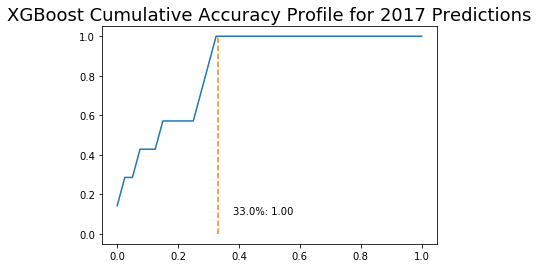

In [210]:
get_cap('XGBoost', '2017', 0.33)

## From the cumulative accuracy profile curve, we can see that all of the states that will see an increase in gun violence for 2017 were within the top 14 states XGBoost classified as most likely. 

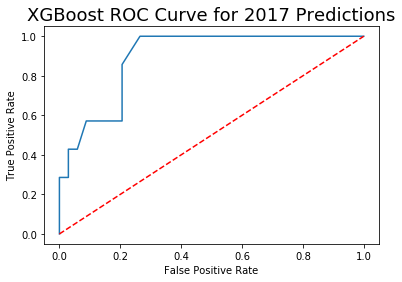

In [224]:
get_roc_curve('XGBoost', '2017')

In [226]:
features = list(annual_df.drop(extra_columns, axis=1).dropna(axis=1).columns)

importances_df = pd.DataFrame()
importances_df['feature'] = features
importances = trained_models['XGBoost'].best_estimator_.feature_importances_
importances_df['xgboost importance'] = importances

In [227]:
importances_df.sort_values('xgboost importance', ascending=False).head(15)

,feature,xgboost importance
2,gun_deaths,0.290625
6,gun_deaths_change,0.221875
3,this_year,0.209375
42,lawtotal,0.087500
87,state_Florida,0.043750
1,republican,0.043750
10,universalpermith,0.025000
0,democrat,0.015625
71,statechecks_statechecksh_old,0.015625
78,lawtotal_old,0.015625


In [ ]:
## We can see that the top provisions XGBoost used were ones regarding permits on handguns, 

## Once again, the limited availability of our features seemed to limit our model's performance. Many of the features that we saw had correlation with gun violence during the visualization stages were unusable because they would limit the training data too much.

## I think it would be a worthy investment to continue to keep track of data such as alcohol abuse, mental health, weapons registered, etc. as we may be able to gather enough data to use them in our modeling.